# estimate $p(\theta_g\,|\,X)$ using a normalizing flow

More specifically, we'll be estimating 
$$p(M_{\rm gas}, M_*, V_{\rm max}, Z_*, R_* | M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$$


In [1]:
import os
import h5py 
import numpy as np

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

## load CAMELS data set

In [5]:
dat_dir = '/tigress/chhahn/cgpop/'
f = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
props = f['props'][...].T
f.close()

In [6]:
props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [7]:
props = props[np.isfinite(props[:,6])]

In [8]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{\rm SN1}$', r'$A_{\rm AGN1}$', r'$A_{\rm SN2}$', r'$A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

In [9]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1]

## forward model noise into the predicted photometry

In [10]:
import astropy.table as aTable

In [11]:
nsa = aTable.Table.read(os.path.join(dat_dir, 'nsa_v0_1_2.fits'))

In [12]:
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

/home/chhahn/.conda/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.


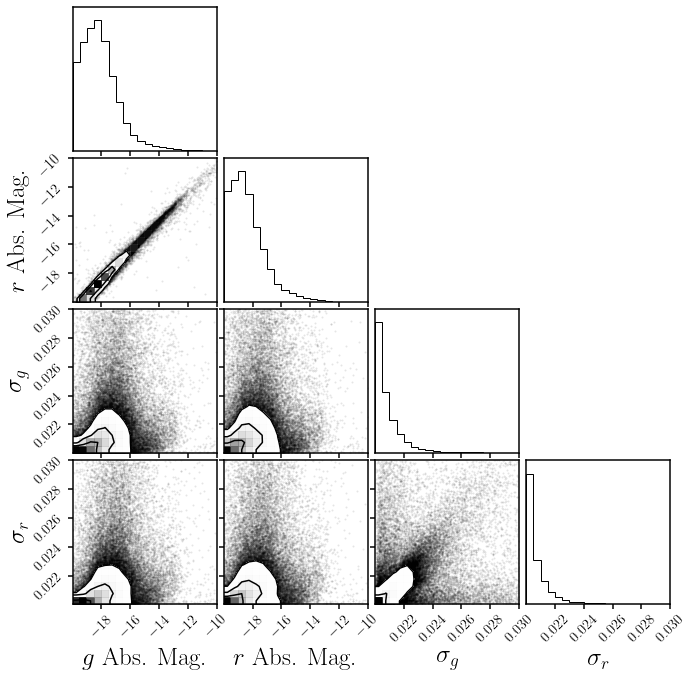

In [13]:
fig = DFM.corner(np.array([absmag_nsa[:,0], absmag_nsa[:,1], ivar_absmag_nsa[:,0]**-0.5, ivar_absmag_nsa[:,1]**-0.5]).T, 
                 labels=['$g$ Abs. Mag.', '$r$ Abs. Mag.', '$\sigma_g$', '$\sigma_r$'], label_kwargs={'fontsize': 25},
                 range=[(-20., -10.), (-20., -10.), (0.02, 0.03), (0.02, 0.03)])

In [10]:
absmag_sigmas = np.random.uniform(0.02, 0.03, size=(props.shape[0], len(iobs)))
absmags = props[:,np.array(iobs)] + absmag_sigmas * np.random.normal(size=(props.shape[0], len(iobs)))

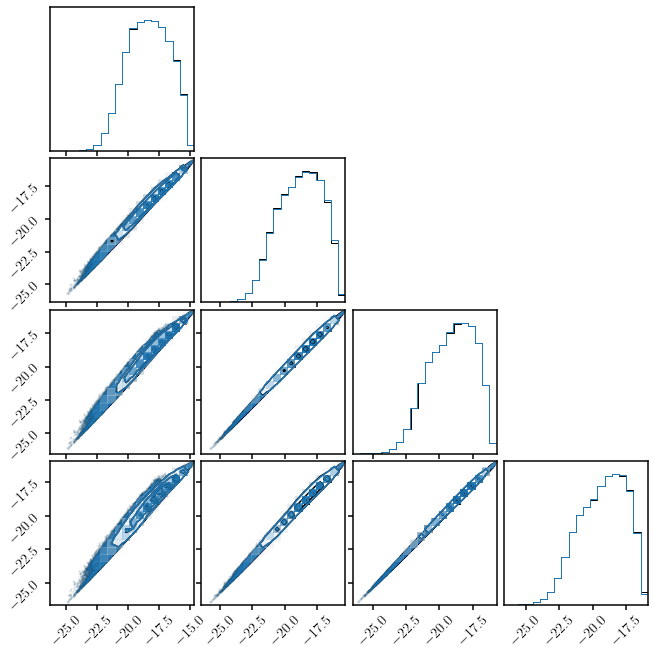

In [11]:
fig = DFM.corner(absmags, color='k')
_ = DFM.corner(props[:,np.array(iobs)], color='C0', fig=fig)

# $p(M_{\rm gas}, M_*, V_{\rm max}, Z_*, R_* , M_g, M_r, M_i, M_z, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$


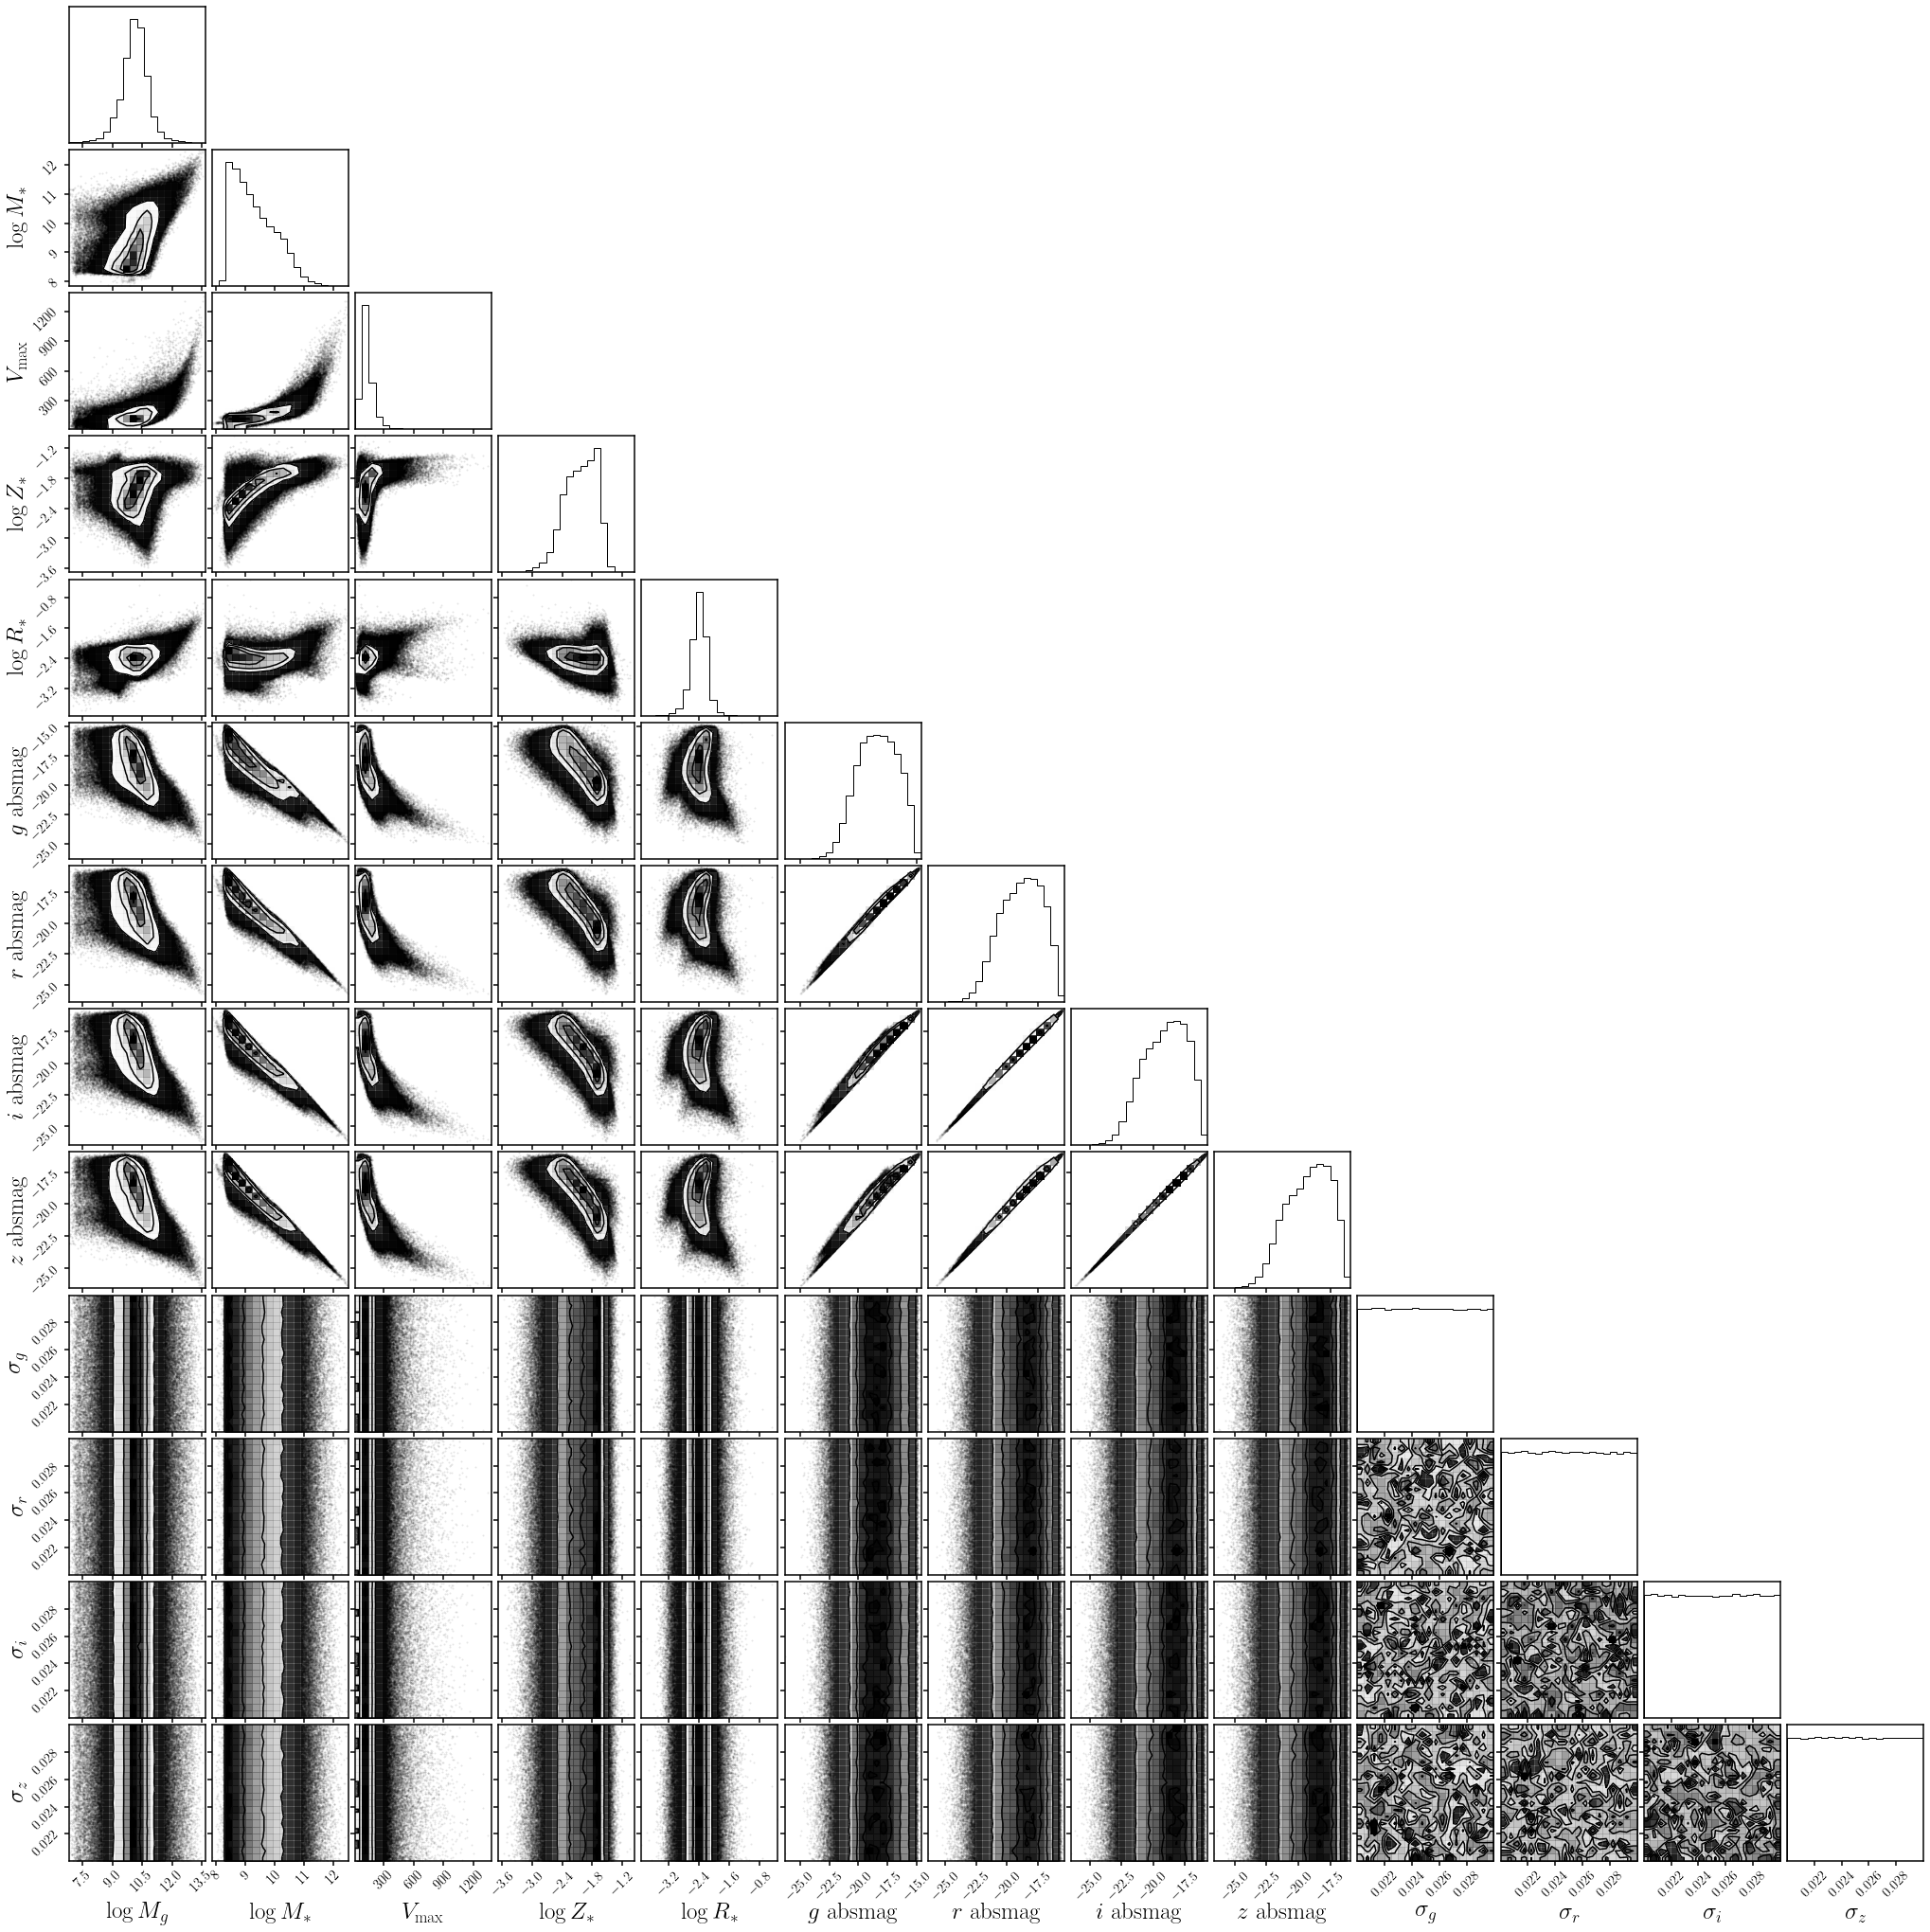

In [12]:
fig = DFM.corner(np.concatenate([props[:,igals], absmags, absmag_sigmas], axis=1),
                 labels=[lbls[i] for i in igals + iobs]+[r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
                 label_kwargs={'fontsize': 25})

# train normalizing flow

In [13]:
prior_low = [6.81, 7.85, 12.89, -3.67, -3.919]
prior_high = [13.65, 12.51, 1400, 0, 0]
lower_bounds = torch.tensor(prior_low)
upper_bounds = torch.tensor(prior_high)

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=device)

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


In [14]:
ishuffle = np.arange(props.shape[0])
np.random.shuffle(ishuffle)

N_train = int(0.8 * props.shape[0])
x_train = np.concatenate([absmags, absmag_sigmas], axis=1)[ishuffle[:N_train]]
y_train = props[:,igals][ishuffle[:N_train]]

N_test = props.shape[0] - N_train
x_test = np.concatenate([absmags, absmag_sigmas], axis=1)[ishuffle[N_train:]]
y_test = props[:,igals][ishuffle[N_train:]]

In [15]:
nhidden = 256
nblocks = 5

anpe = Inference.SNPE(prior=prior, 
                      density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks), 
                      device=device)
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)).to(device), 
    torch.as_tensor(x_train.astype(np.float32)).to(device))

p_y_x_estimator = anpe.train()
qphi = anpe.build_posterior(p_y_x_estimator)

 Neural network successfully converged after 45 epochs.

## validate normalizing flow

In [17]:
rank_thetas = [] 
for i in np.arange(x_test.shape[0])[::10]: 
    # sample posterior p(theta | x_test_i)
    y_prime = qphi.sample((10000,), 
            x=torch.as_tensor(x_test[i].astype(np.float32)).to(device), 
            show_progress_bars=False)
    y_prime = np.array(y_prime.detach().cpu())

    # calculate percentile score and rank
    rank_theta = []
    for itheta in range(y_test.shape[1]): 
        rank_theta.append(np.sum(y_prime[:,itheta] < y_test[i,itheta]))
    rank_thetas.append(rank_theta)

[]

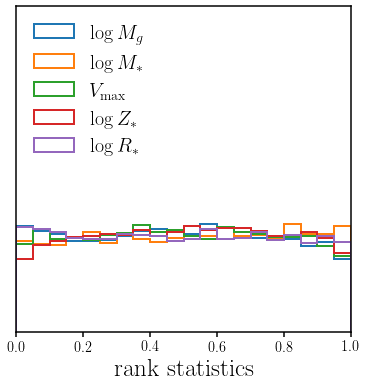

In [30]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
for i in range(y_test.shape[1]): 
    _ = sub.hist(np.array(rank_thetas)[:,i]/10000., 
                 range=(0, 1), bins=20, histtype='step', 
                 linewidth=2, label=lbls[igals[i]])
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('rank statistics', fontsize=25)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 2e3)
sub.set_yticks([])

## save normalizing flow

In [31]:
torch.save(qphi, os.path.join(dat_dir, 'qphi.thetag_X.pt'))